# Bonus2: Build a Supervised Autoencoder.

### Name: Xing Fang



PCA and the standard autoencoder are unsupervised dimensionality reduction methods, and their learned features are not discriminative. If you build a classifier upon the low-dimenional features extracted by PCA and autoencoder, you will find the classification accuracy very poor.

Linear discriminant analysis (LDA) is a traditionally supervised dimensionality reduction method for learning low-dimensional features which are highly discriminative. Likewise, can we extend autoencoder to supervised leanring?



**You are required to build and train a supervised autoencoder look like the following.** You are required to add other layers properly to alleviate overfitting.


![Network Structure](https://github.com/wangshusen/CS583A-2019Spring/blob/master/homework/HM5/supervised_ae.png?raw=true "NetworkStructure")


## 0. You will do the following:

1. Read and run my code to train a standard dense autoencoder.

2. Build and train a supervised autoencoder, visual the low-dim features and the reconstructions, and evaluate whether the learned low-dim features are discriminative.
    
3. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain the code and the output after execution.
    
    
    
4. Upload this .HTML file to your Google Drive, Dropbox, or Github repo.

4. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2020S/blob/master/homework/Bonus2/Bonus2.html


## 1. Data preparation

### 1.1. Load data


In [1]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(60000, 28*28).astype('float32') / 255.
x_test = x_test.reshape(10000, 28*28).astype('float32') / 255.

print('Shape of x_train: ' + str(x_train.shape)) 
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Using TensorFlow backend.
C:\anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as

Shape of x_train: (60000, 784)
Shape of x_test: (10000, 784)
Shape of y_train: (60000,)
Shape of y_test: (10000,)


### 1.2. One-hot encode the labels

In the input, a label is a scalar in $\{0, 1, \cdots , 9\}$. One-hot encode transform such a scalar to a $10$-dim vector. E.g., a scalar ```y_train[j]=3``` is transformed to the vector ```y_train_vec[j]=[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]```.

1. Define a function ```to_one_hot``` that transforms an $n\times 1$ array to a $n\times 10$ matrix.

2. Apply the function to ```y_train``` and ```y_test```.

In [2]:
import numpy

def to_one_hot(y, num_class=10):
    results = numpy.zeros((len(y), num_class))
    for i, label in enumerate(y):
        results[i, label] = 1.
    return results

y_train_vec = to_one_hot(y_train)
y_test_vec = to_one_hot(y_test)

print('Shape of y_train_vec: ' + str(y_train_vec.shape))
print('Shape of y_test_vec: ' + str(y_test_vec.shape))

print(y_train[0])
print(y_train_vec[0])

Shape of y_train_vec: (60000, 10)
Shape of y_test_vec: (10000, 10)
5
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


### 1.3. Randomly partition the training set to training and validation sets

Randomly partition the 60K training samples to 2 sets:
* a training set containing 10K samples
* a validation set containing 50K samples


In [45]:
rand_indices = numpy.random.permutation(60000)
train_indices = rand_indices[0:10000]
valid_indices = rand_indices[10000:60000]

x_val = x_train[valid_indices, :]
y_val = y_train_vec[valid_indices, :]

x_tr = x_train[train_indices, :]
y_tr = y_train_vec[train_indices, :]

print('Shape of x_tr: ' + str(x_tr.shape))
print('Shape of y_tr: ' + str(y_tr.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))

Shape of x_tr: (10000, 784)
Shape of y_tr: (10000, 10)
Shape of x_val: (50000, 784)
Shape of y_val: (50000, 10)


## 2. Build an unsupervised  autoencoder and tune its hyper-parameters

1. Build a dense autoencoder model
2. Use the validation data to tune the hyper-parameters (e.g., network structure, and optimization algorithm)
    * Do NOT use test data for hyper-parameter tuning!!!
    
3. Try to achieve a validation loss as low as possible.
4. Evaluate the model on the test set.
5. Visualize the low-dim features and reconstructions.

### 2.1. Build the model

In [50]:
from keras.layers import Dense, Input
from keras import models

input_img = Input(shape=(784,), name='input_img')

encode1 = Dense(128, activation='relu', name='encode1')(input_img)
encode2 = Dense(32, activation='relu', name='encode2')(encode1)
encode3 = Dense(8, activation='relu', name='encode3')(encode2)
bottleneck = Dense(2, activation='relu', name='bottleneck')(encode3)
decode1 = Dense(8, activation='relu', name='decode1')(bottleneck)
decode2 = Dense(32, activation='relu', name='decode2')(decode1)
decode3 = Dense(128, activation='relu', name='decode3')(decode2)
decode4 = Dense(784, activation='relu', name='decode4')(decode3)

ae = models.Model(input_img, decode4)

ae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 784)               0         
_________________________________________________________________
encode1 (Dense)              (None, 128)               100480    
_________________________________________________________________
encode2 (Dense)              (None, 32)                4128      
_________________________________________________________________
encode3 (Dense)              (None, 8)                 264       
_________________________________________________________________
bottleneck (Dense)           (None, 2)                 18        
_________________________________________________________________
decode1 (Dense)              (None, 8)                 24        
_________________________________________________________________
decode2 (Dense)              (None, 32)                288       
__________

In [5]:
# print the network structure to a PDF file

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model

SVG(model_to_dot(ae, show_shapes=False).create(prog='dot', format='svg'))

plot_model(
    model=ae, show_shapes=False,
    to_file='unsupervised_ae.pdf'
)

# you can find the file "unsupervised_ae.pdf" in the current directory.

### 2.2. Train the model and tune the hyper-parameters

In [78]:
def un_model(lr):
    input_img = Input(shape=(784,), name='input_img')

    encode1 = Dense(128, activation='relu', name='encode1')(input_img)
    encode2 = Dense(32, activation='relu', name='encode2')(encode1)
    encode3 = Dense(8, activation='relu', name='encode3')(encode2)
    bottleneck = Dense(2, activation='relu', name='bottleneck')(encode3)
    decode1 = Dense(8, activation='relu', name='decode1')(bottleneck)
    decode2 = Dense(32, activation='relu', name='decode2')(decode1)
    decode3 = Dense(128, activation='relu', name='decode3')(decode2)
    decode4 = Dense(784, activation='relu', name='decode4')(decode3)

    ae = models.Model(input_img, decode4)
    ae.compile(loss='mean_squared_error',
               optimizer=optimizers.RMSprop(lr=lr))
    return ae

In [82]:
def find_best_lr(learning_rate):
    loss = []
    for i in learning_rate:
        rand_indices = numpy.random.permutation(60000)
        train_indices = rand_indices[0:10000]
        valid_indices = rand_indices[10000:60000]

        x_val = x_train[valid_indices, :]
        y_val = y_train_vec[valid_indices, :]

        x_tr = x_train[train_indices, :]
        y_tr = y_train_vec[train_indices, :]
        
        ae = un_model(i)
        history = ae.fit(x_tr, x_tr, 
                         batch_size=128, 
                         epochs=100, 
                         validation_data=(x_val, x_val))
        loss_i = history.history['val_loss'][-1]
        loss.append(loss_i)
        
    best_lr = learning_rate[loss.index(min(loss))]
    return best_lr

def best_model(best_lr):
    rand_indices = numpy.random.permutation(60000)
    train_indices = rand_indices[0:10000]
    valid_indices = rand_indices[10000:60000]

    x_val = x_train[valid_indices, :]
    y_val = y_train_vec[valid_indices, :]

    x_tr = x_train[train_indices, :]
    y_tr = y_train_vec[train_indices, :]
    
    ae = un_model(best_lr)
    history = ae.fit(x_tr, x_tr, 
                         batch_size=128, 
                         epochs=100, 
                         validation_data=(x_val, x_val))
    return history

In [80]:
learning_rate = [1e-2, 1e-3, 1e-4]
best_lr = find_best_lr(learning_rate)
print(best_lr)

Train on 10000 samples, validate on 50000 samples
Epoch 1/100
10000/10000 [==============================] - 3s - loss: 0.1530 - val_loss: 0.1031
Epoch 2/100
10000/10000 [==============================] - 1s - loss: 0.0881 - val_loss: 0.0790
Epoch 3/100
10000/10000 [==============================] - 1s - loss: 0.0774 - val_loss: 0.0755
Epoch 4/100
10000/10000 [==============================] - 1s - loss: 0.0711 - val_loss: 0.0667
Epoch 5/100
10000/10000 [==============================] - 1s - loss: 0.0650 - val_loss: 0.0636
Epoch 6/100
10000/10000 [==============================] - 1s - loss: 0.0619 - val_loss: 0.0604
Epoch 7/100
10000/10000 [==============================] - 1s - loss: 0.0590 - val_loss: 0.0577
Epoch 8/100
10000/10000 [==============================] - 1s - loss: 0.0574 - val_loss: 0.0569
Epoch 9/100
10000/10000 [==============================] - 1s - loss: 0.0558 - val_loss: 0.0573
Epoch 10/100
10000/10000 [==============================] - 1s - loss: 0.0546 - val_lo

10000/10000 [==============================] - 1s - loss: 0.0457 - val_loss: 0.0494
Epoch 86/100
10000/10000 [==============================] - 1s - loss: 0.0459 - val_loss: 0.0477
Epoch 87/100
10000/10000 [==============================] - 1s - loss: 0.0459 - val_loss: 0.0508
Epoch 88/100
10000/10000 [==============================] - 1s - loss: 0.0457 - val_loss: 0.0509
Epoch 89/100
10000/10000 [==============================] - 1s - loss: 0.0457 - val_loss: 0.0461
Epoch 90/100
10000/10000 [==============================] - 1s - loss: 0.0458 - val_loss: 0.0502
Epoch 91/100
10000/10000 [==============================] - 1s - loss: 0.0455 - val_loss: 0.0470
Epoch 92/100
10000/10000 [==============================] - 1s - loss: 0.0454 - val_loss: 0.0460
Epoch 93/100
10000/10000 [==============================] - 1s - loss: 0.0457 - val_loss: 0.0504
Epoch 94/100
10000/10000 [==============================] - 1s - loss: 0.0456 - val_loss: 0.0486
Epoch 95/100
10000/10000 [=================

10000/10000 [==============================] - 1s - loss: 0.0446 - val_loss: 0.0482
Epoch 70/100
10000/10000 [==============================] - 1s - loss: 0.0445 - val_loss: 0.0478
Epoch 71/100
10000/10000 [==============================] - 1s - loss: 0.0445 - val_loss: 0.0486
Epoch 72/100
10000/10000 [==============================] - 1s - loss: 0.0444 - val_loss: 0.0475
Epoch 73/100
10000/10000 [==============================] - 1s - loss: 0.0444 - val_loss: 0.0481
Epoch 74/100
10000/10000 [==============================] - 1s - loss: 0.0443 - val_loss: 0.0476
Epoch 75/100
10000/10000 [==============================] - 1s - loss: 0.0443 - val_loss: 0.0486
Epoch 76/100
10000/10000 [==============================] - 1s - loss: 0.0443 - val_loss: 0.0477
Epoch 77/100
10000/10000 [==============================] - 1s - loss: 0.0441 - val_loss: 0.0473
Epoch 78/100
10000/10000 [==============================] - 1s - loss: 0.0439 - val_loss: 0.0480
Epoch 79/100
10000/10000 [=================

10000/10000 [==============================] - 1s - loss: 0.0638 - val_loss: 0.0643
Epoch 54/100
10000/10000 [==============================] - 1s - loss: 0.0638 - val_loss: 0.0641
Epoch 55/100
10000/10000 [==============================] - 1s - loss: 0.0637 - val_loss: 0.0641
Epoch 56/100
10000/10000 [==============================] - 1s - loss: 0.0636 - val_loss: 0.0640
Epoch 57/100
10000/10000 [==============================] - 1s - loss: 0.0635 - val_loss: 0.0639
Epoch 58/100
10000/10000 [==============================] - 1s - loss: 0.0635 - val_loss: 0.0639
Epoch 59/100
10000/10000 [==============================] - 1s - loss: 0.0634 - val_loss: 0.0639
Epoch 60/100
10000/10000 [==============================] - 1s - loss: 0.0633 - val_loss: 0.0638
Epoch 61/100
10000/10000 [==============================] - 1s - loss: 0.0632 - val_loss: 0.0637
Epoch 62/100
10000/10000 [==============================] - 1s - loss: 0.0632 - val_loss: 0.0636
Epoch 63/100
10000/10000 [=================

In [93]:
history = best_model(best_lr)

Train on 10000 samples, validate on 50000 samples
Epoch 1/100
10000/10000 [==============================] - 3s - loss: 0.0826 - val_loss: 0.0794
Epoch 2/100
10000/10000 [==============================] - 1s - loss: 0.0779 - val_loss: 0.0766
Epoch 3/100
10000/10000 [==============================] - 1s - loss: 0.0758 - val_loss: 0.0746
Epoch 4/100
10000/10000 [==============================] - 1s - loss: 0.0739 - val_loss: 0.0729
Epoch 5/100
10000/10000 [==============================] - 1s - loss: 0.0717 - val_loss: 0.0711
Epoch 6/100
10000/10000 [==============================] - 1s - loss: 0.0701 - val_loss: 0.0696
Epoch 7/100
10000/10000 [==============================] - 1s - loss: 0.0687 - val_loss: 0.0684
Epoch 8/100
10000/10000 [==============================] - 1s - loss: 0.0677 - val_loss: 0.0674
Epoch 9/100
10000/10000 [==============================] - 2s - loss: 0.0663 - val_loss: 0.0651
Epoch 10/100
10000/10000 [==============================] - 2s - loss: 0.0644 - val_lo

10000/10000 [==============================] - 1s - loss: 0.0427 - val_loss: 0.0454
Epoch 86/100
10000/10000 [==============================] - 1s - loss: 0.0426 - val_loss: 0.0456
Epoch 87/100
10000/10000 [==============================] - 1s - loss: 0.0426 - val_loss: 0.0455
Epoch 88/100
10000/10000 [==============================] - 1s - loss: 0.0426 - val_loss: 0.0456
Epoch 89/100
10000/10000 [==============================] - 1s - loss: 0.0425 - val_loss: 0.0453
Epoch 90/100
10000/10000 [==============================] - 1s - loss: 0.0425 - val_loss: 0.0455
Epoch 91/100
10000/10000 [==============================] - 1s - loss: 0.0424 - val_loss: 0.0462
Epoch 92/100
10000/10000 [==============================] - 2s - loss: 0.0424 - val_loss: 0.0451
Epoch 93/100
10000/10000 [==============================] - 1s - loss: 0.0424 - val_loss: 0.0457
Epoch 94/100
10000/10000 [==============================] - 1s - loss: 0.0424 - val_loss: 0.0457
Epoch 95/100
10000/10000 [=================

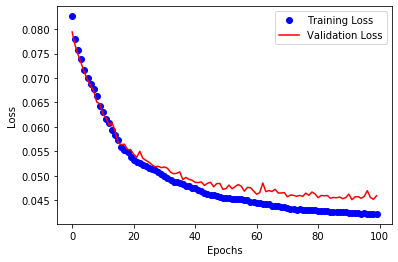

In [94]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 2.3. Visualize the reconstructed test images

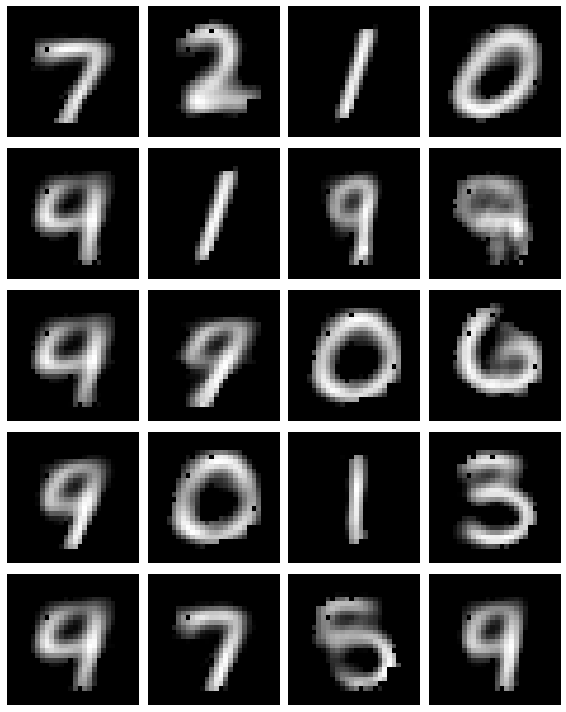

In [95]:
ae_output = ae.predict(x_test).reshape((10000, 28, 28))

ROW = 5
COLUMN = 4

x = ae_output
fname = 'reconstruct_ae.pdf'

fig, axes = plt.subplots(nrows=ROW, ncols=COLUMN, figsize=(8, 10))
for ax, i in zip(axes.flat, numpy.arange(ROW*COLUMN)):
    image = x[i].reshape(28, 28)
    ax.imshow(image, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.savefig(fname)
plt.show()

### 2.4. Evaluate the model on the test set

Do NOT used the test set until now. Make sure that your model parameters and hyper-parameters are independent of the test set.

In [96]:
loss = ae.evaluate(x_test, x_test)
print('loss = ' + str(loss))

 9408/10000 [===========================>..] - ETA: 0sloss = 0.04375330807566643


### 2.5. Visualize the low-dimensional features

In [97]:
# build the encoder network
ae_encoder = models.Model(input_img, bottleneck)
ae_encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 784)               0         
_________________________________________________________________
encode1 (Dense)              (None, 128)               100480    
_________________________________________________________________
encode2 (Dense)              (None, 32)                4128      
_________________________________________________________________
encode3 (Dense)              (None, 8)                 264       
_________________________________________________________________
bottleneck (Dense)           (None, 2)                 18        
Total params: 104,890
Trainable params: 104,890
Non-trainable params: 0
_________________________________________________________________


In [98]:
# extract low-dimensional features from the test data
encoded_test = ae_encoder.predict(x_test)
print('Shape of encoded_test: ' + str(encoded_test.shape))

Shape of encoded_test: (10000, 2)


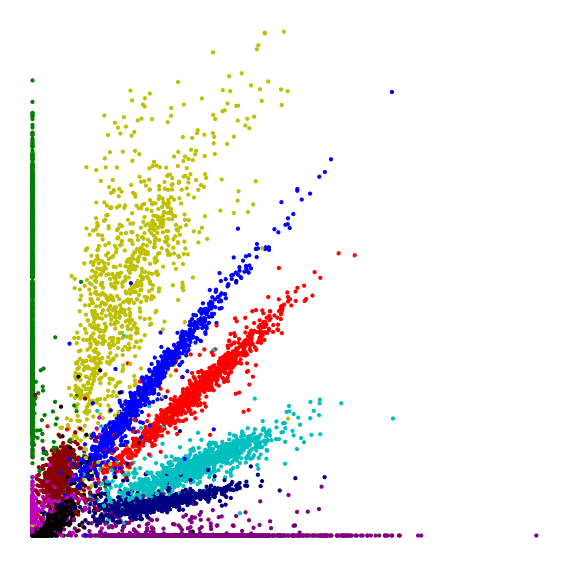

In [99]:
colors = numpy.array(['r', 'g', 'b', 'm', 'c', 'k', 'y', 'purple', 'darkred', 'navy'])
colors_test = colors[y_test]


import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(8, 8))
plt.scatter(encoded_test[:, 0], encoded_test[:, 1], s=10, c=colors_test, edgecolors=colors_test)
plt.axis('off')
plt.tight_layout()
fname = 'ae_code.pdf'
plt.savefig(fname)

#### Remark:

Judging from the visualization, the low-dim features seems not discriminative, as 2D features from different classes are mixed. Let quantatively find out whether they are discriminative.

## 3. Are the learned low-dim features discriminative?

To find the answer, lets train a classifier on the training set (the extracted 2-dim features) and evaluation on the test set.

In [100]:
# extract the 2D features from the training, validation, and test samples
f_tr = ae_encoder.predict(x_tr)
f_val = ae_encoder.predict(x_val)
f_te = ae_encoder.predict(x_test)

print('Shape of f_tr: ' + str(f_tr.shape))
print('Shape of f_te: ' + str(f_te.shape))

Shape of f_tr: (10000, 2)
Shape of f_te: (10000, 2)


In [101]:
from keras.layers import Dense, Input
from keras import models

input_feat = Input(shape=(2,))

hidden1 = Dense(128, activation='relu')(input_feat)
hidden2 = Dense(128, activation='relu')(hidden1)
output = Dense(10, activation='softmax')(hidden2)

classifier = models.Model(input_feat, output)

classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               384       
_________________________________________________________________
dense_8 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_9 (Dense)              (None, 10)                1290      
Total params: 18,186
Trainable params: 18,186
Non-trainable params: 0
_________________________________________________________________


In [102]:
classifier.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.RMSprop(lr=1E-4),
                  metrics=['acc'])

history = classifier.fit(f_tr, y_tr, 
                        batch_size=32, 
                        epochs=30, 
                        validation_data=(f_val, y_val))

Train on 10000 samples, validate on 50000 samples
Epoch 1/30
10000/10000 [==============================] - 3s - loss: 1.6740 - acc: 0.5048 - val_loss: 1.3402 - val_acc: 0.6263
Epoch 2/30
10000/10000 [==============================] - 2s - loss: 1.0780 - acc: 0.6975 - val_loss: 1.0028 - val_acc: 0.7115
Epoch 3/30
10000/10000 [==============================] - 2s - loss: 0.7771 - acc: 0.8348 - val_loss: 0.7903 - val_acc: 0.8227
Epoch 4/30
10000/10000 [==============================] - 2s - loss: 0.5542 - acc: 0.9319 - val_loss: 0.6259 - val_acc: 0.9105
Epoch 5/30
10000/10000 [==============================] - 3s - loss: 0.3757 - acc: 0.9792 - val_loss: 0.5086 - val_acc: 0.9189
Epoch 6/30
10000/10000 [==============================] - 3s - loss: 0.2491 - acc: 0.9828 - val_loss: 0.4451 - val_acc: 0.9207
Epoch 7/30
10000/10000 [==============================] - 2s - loss: 0.1745 - acc: 0.9835 - val_loss: 0.4181 - val_acc: 0.9209
Epoch 8/30
10000/10000 [==============================] - 2s 

### Conclusion

Using the 2D features, the validation accuracy is 60~70%. Recall that using the original data, the accuracy is about 98%. Obviously, the 2D features are not very discriminative.

We are going to build a supervised autoencode model for learning low-dimensional discriminative features.

## 4. Build a supervised autoencoder model


**You are required to build and train a supervised autoencoder look like the following.** (Not necessary the same.) You are required to add other layers properly to alleviate overfitting.


![Network Structure](https://github.com/wangshusen/CS583A-2019Spring/blob/master/homework/HM5/supervised_ae.png?raw=true "NetworkStructure")


### 4.1. Build the network

In [103]:
# build the supervised autoencoder network
from keras.layers import Dense, Input
from keras import models, regularizers

input_img = Input(shape=(784,), name='input_img')

# encoder network
encode1 = Dense(128, activation='relu', name='encode1')(input_img)
encode2 = Dense(32, activation='relu', name='encode2')(encode1)
encode3 = Dense(8, activation='relu', name='encode3')(encode2)
# The width of the bottleneck layer must be exactly 2.
bottleneck = Dense(2, activation='relu', name='bottleneck')(encode3)

# decoder network
decode1 = Dense(8, activation='relu', name='decode1')(bottleneck)
decode2 = Dense(32, activation='relu', name='decode2')(decode1)
decode3 = Dense(128, activation='relu', name='decode3')(decode2)
decode4 = Dense(784, activation='relu', name='decode4')(decode3)


# build a classifier upon the bottleneck layer
classifier1 = Dense(128, activation='relu', name='classifier1')(bottleneck)
classifier2 = Dense(128, activation='relu', name='classifier2')(classifier1)
classifier3 = Dense(10, activation='softmax', name='classifier3')(classifier2)

In [104]:
# connect the input and the two outputs
sae = models.Model(input_img, [decode4, classifier3])

sae.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_img (InputLayer)           (None, 784)           0                                            
____________________________________________________________________________________________________
encode1 (Dense)                  (None, 128)           100480      input_img[0][0]                  
____________________________________________________________________________________________________
encode2 (Dense)                  (None, 32)            4128        encode1[0][0]                    
____________________________________________________________________________________________________
encode3 (Dense)                  (None, 8)             264         encode2[0][0]                    
___________________________________________________________________________________________

In [19]:
# print the network structure to a PDF file

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model

SVG(model_to_dot(sae, show_shapes=False).create(prog='dot', format='svg'))

plot_model(
    model=sae, show_shapes=False,
    to_file='supervised_ae.pdf'
)

# you can find the file "supervised_ae.pdf" in the current directory.

### 4.2. Train the new model and tune the hyper-parameters

The new model has multiple output. Thus we specify **multiple** loss functions and their weights. 

In [105]:
def model(loss_weight):
    input_img = Input(shape=(784,), name='input_img')

    # encoder network
    encode1 = Dense(128, activation='relu', name='encode1')(input_img)
    encode2 = Dense(32, activation='relu', name='encode2')(encode1)
    encode3 = Dense(8, activation='relu', name='encode3')(encode2)
    # The width of the bottleneck layer must be exactly 2.
    bottleneck = Dense(2, activation='relu', name='bottleneck')(encode3)

    # decoder network
    decode1 = Dense(8, activation='relu', name='decode1')(bottleneck)
    decode2 = Dense(32, activation='relu', name='decode2')(decode1)
    decode3 = Dense(128, activation='relu', name='decode3')(decode2)
    decode4 = Dense(784, activation='relu', name='decode4')(decode3)


    # build a classifier upon the bottleneck layer
    classifier1 = Dense(128, activation='relu', name='classifier1')(bottleneck)
    classifier2 = Dense(128, activation='relu', name='classifier2')(classifier1)
    classifier3 = Dense(10, activation='softmax', name='classifier3')(classifier2)
    
    sae = models.Model(input_img, [decode4, classifier3])

    sae.compile(loss=['mean_squared_error', 'categorical_crossentropy'],
            loss_weights=loss_weight, # to be tuned
            optimizer=optimizers.RMSprop(lr=1E-3))
    
    return sae


In [111]:
def best_weight(loss_weights):
    loss = []
    for i in loss_weights:
        rand_indices = numpy.random.permutation(60000)
        train_indices = rand_indices[0:10000]
        valid_indices = rand_indices[10000:60000]

        x_val = x_train[valid_indices, :]
        y_val = y_train_vec[valid_indices, :]

        x_tr = x_train[train_indices, :]
        y_tr = y_train_vec[train_indices, :]
        
        sae = model(i)
        history = sae.fit(x_tr, [x_tr,y_tr], 
                         batch_size=128, 
                         epochs=100, 
                         validation_data=(x_val, [x_val,y_val]))
        loss_i = history.history['val_loss'][-1]
        loss.append(loss_i)
        
    best_weight = loss_weights[loss.index(min(loss))]
    return best_weight

def best_model(best_weight):
    rand_indices = numpy.random.permutation(60000)
    train_indices = rand_indices[0:10000]
    valid_indices = rand_indices[10000:60000]

    x_val = x_train[valid_indices, :]
    y_val = y_train_vec[valid_indices, :]

    x_tr = x_train[train_indices, :]
    y_tr = y_train_vec[train_indices, :]
    
    sae = model(best_weight)
    history = sae.fit(x_tr, [x_tr,y_tr], 
                         batch_size=128, 
                         epochs=100, 
                         validation_data=(x_val, [x_val,y_val]))
    return history

In [109]:
loss_weights = [[1,0.5], [0.8,0.8], [0.5,1]]
best_weight = best_weight(loss_weights)
print(best_weight)

Train on 10000 samples, validate on 50000 samples
Epoch 1/100
10000/10000 [==============================] - 3s - loss: 0.9690 - decode4_loss: 0.0827 - classifier3_loss: 1.7726 - val_loss: 0.8374 - val_decode4_loss: 0.0732 - val_classifier3_loss: 1.5285
Epoch 2/100
10000/10000 [==============================] - 1s - loss: 0.6866 - decode4_loss: 0.0700 - classifier3_loss: 1.2331 - val_loss: 0.6817 - val_decode4_loss: 0.0694 - val_classifier3_loss: 1.2247
Epoch 3/100
10000/10000 [==============================] - 1s - loss: 0.5584 - decode4_loss: 0.0680 - classifier3_loss: 0.9809 - val_loss: 0.6105 - val_decode4_loss: 0.0677 - val_classifier3_loss: 1.0858
Epoch 4/100
10000/10000 [==============================] - 1s - loss: 0.4671 - decode4_loss: 0.0655 - classifier3_loss: 0.8032 - val_loss: 0.5300 - val_decode4_loss: 0.0651 - val_classifier3_loss: 0.9297
Epoch 5/100
10000/10000 [==============================] - 1s - loss: 0.3912 - decode4_loss: 0.0633 - classifier3_loss: 0.6558 - val_l

10000/10000 [==============================] - 1s - loss: 0.0755 - decode4_loss: 0.0550 - classifier3_loss: 0.0411 - val_loss: 0.3120 - val_decode4_loss: 0.0555 - val_classifier3_loss: 0.5130
Epoch 41/100
10000/10000 [==============================] - 1s - loss: 0.0721 - decode4_loss: 0.0549 - classifier3_loss: 0.0344 - val_loss: 0.3288 - val_decode4_loss: 0.0557 - val_classifier3_loss: 0.5461
Epoch 42/100
10000/10000 [==============================] - 2s - loss: 0.0735 - decode4_loss: 0.0549 - classifier3_loss: 0.0372 - val_loss: 0.3153 - val_decode4_loss: 0.0556 - val_classifier3_loss: 0.5194
Epoch 43/100
10000/10000 [==============================] - 2s - loss: 0.0700 - decode4_loss: 0.0547 - classifier3_loss: 0.0305 - val_loss: 0.3271 - val_decode4_loss: 0.0554 - val_classifier3_loss: 0.5433
Epoch 44/100
10000/10000 [==============================] - 2s - loss: 0.0713 - decode4_loss: 0.0544 - classifier3_loss: 0.0338 - val_loss: 0.3227 - val_decode4_loss: 0.0553 - val_classifier3_l

10000/10000 [==============================] - 1s - loss: 0.0645 - decode4_loss: 0.0511 - classifier3_loss: 0.0269 - val_loss: 0.3764 - val_decode4_loss: 0.0525 - val_classifier3_loss: 0.6480
Epoch 81/100
10000/10000 [==============================] - 2s - loss: 0.0640 - decode4_loss: 0.0511 - classifier3_loss: 0.0257 - val_loss: 0.3814 - val_decode4_loss: 0.0526 - val_classifier3_loss: 0.6576
Epoch 82/100
10000/10000 [==============================] - 2s - loss: 0.0653 - decode4_loss: 0.0511 - classifier3_loss: 0.0284 - val_loss: 0.3920 - val_decode4_loss: 0.0526 - val_classifier3_loss: 0.6788
Epoch 83/100
10000/10000 [==============================] - 2s - loss: 0.0621 - decode4_loss: 0.0508 - classifier3_loss: 0.0226 - val_loss: 0.3818 - val_decode4_loss: 0.0522 - val_classifier3_loss: 0.6591
Epoch 84/100
10000/10000 [==============================] - 2s - loss: 0.0626 - decode4_loss: 0.0507 - classifier3_loss: 0.0238 - val_loss: 0.3860 - val_decode4_loss: 0.0520 - val_classifier3_l

10000/10000 [==============================] - 2s - loss: 0.0879 - decode4_loss: 0.0509 - classifier3_loss: 0.0589 - val_loss: 0.3636 - val_decode4_loss: 0.0515 - val_classifier3_loss: 0.4029
Epoch 20/100
10000/10000 [==============================] - 1s - loss: 0.0866 - decode4_loss: 0.0509 - classifier3_loss: 0.0573 - val_loss: 0.3573 - val_decode4_loss: 0.0515 - val_classifier3_loss: 0.3950
Epoch 21/100
10000/10000 [==============================] - 1s - loss: 0.0837 - decode4_loss: 0.0508 - classifier3_loss: 0.0539 - val_loss: 0.3851 - val_decode4_loss: 0.0515 - val_classifier3_loss: 0.4299
Epoch 22/100
10000/10000 [==============================] - 1s - loss: 0.0805 - decode4_loss: 0.0506 - classifier3_loss: 0.0499 - val_loss: 0.3699 - val_decode4_loss: 0.0513 - val_classifier3_loss: 0.4110
Epoch 23/100
10000/10000 [==============================] - 2s - loss: 0.0801 - decode4_loss: 0.0506 - classifier3_loss: 0.0495 - val_loss: 0.3953 - val_decode4_loss: 0.0517 - val_classifier3_l

10000/10000 [==============================] - 2s - loss: 0.0694 - decode4_loss: 0.0487 - classifier3_loss: 0.0380 - val_loss: 0.4898 - val_decode4_loss: 0.0503 - val_classifier3_loss: 0.5619
Epoch 60/100
10000/10000 [==============================] - 2s - loss: 0.0683 - decode4_loss: 0.0488 - classifier3_loss: 0.0366 - val_loss: 0.4756 - val_decode4_loss: 0.0505 - val_classifier3_loss: 0.5441
Epoch 61/100
10000/10000 [==============================] - 2s - loss: 0.0670 - decode4_loss: 0.0487 - classifier3_loss: 0.0350 - val_loss: 0.5185 - val_decode4_loss: 0.0506 - val_classifier3_loss: 0.5975
Epoch 62/100
10000/10000 [==============================] - 2s - loss: 0.0720 - decode4_loss: 0.0485 - classifier3_loss: 0.0415 - val_loss: 0.5031 - val_decode4_loss: 0.0503 - val_classifier3_loss: 0.5786
Epoch 63/100
10000/10000 [==============================] - 2s - loss: 0.0682 - decode4_loss: 0.0486 - classifier3_loss: 0.0366 - val_loss: 0.5260 - val_decode4_loss: 0.0510 - val_classifier3_l

10000/10000 [==============================] - 1s - loss: 0.0671 - decode4_loss: 0.0475 - classifier3_loss: 0.0364 - val_loss: 0.5516 - val_decode4_loss: 0.0496 - val_classifier3_loss: 0.6398
Epoch 100/100
10000/10000 [==============================] - 2s - loss: 0.0689 - decode4_loss: 0.0476 - classifier3_loss: 0.0385 - val_loss: 0.5780 - val_decode4_loss: 0.0517 - val_classifier3_loss: 0.6708
Train on 10000 samples, validate on 50000 samples
Epoch 1/100
10000/10000 [==============================] - 15s - loss: 0.4371 - decode4_loss: 0.0503 - classifier3_loss: 0.4119 - val_loss: 0.3344 - val_decode4_loss: 0.0513 - val_classifier3_loss: 0.3088
Epoch 2/100
10000/10000 [==============================] - 2s - loss: 0.2827 - decode4_loss: 0.0507 - classifier3_loss: 0.2574 - val_loss: 0.3268 - val_decode4_loss: 0.0515 - val_classifier3_loss: 0.3010
Epoch 3/100
10000/10000 [==============================] - 2s - loss: 0.2329 - decode4_loss: 0.0508 - classifier3_loss: 0.2075 - val_loss: 0.32

10000/10000 [==============================] - 2s - loss: 0.0785 - decode4_loss: 0.0496 - classifier3_loss: 0.0537 - val_loss: 0.4817 - val_decode4_loss: 0.0504 - val_classifier3_loss: 0.4565
Epoch 39/100
10000/10000 [==============================] - 2s - loss: 0.0938 - decode4_loss: 0.0494 - classifier3_loss: 0.0691 - val_loss: 0.4606 - val_decode4_loss: 0.0508 - val_classifier3_loss: 0.4352
Epoch 40/100
10000/10000 [==============================] - 2s - loss: 0.0801 - decode4_loss: 0.0498 - classifier3_loss: 0.0552 - val_loss: 0.5150 - val_decode4_loss: 0.0507 - val_classifier3_loss: 0.4896
Epoch 41/100
10000/10000 [==============================] - 2s - loss: 0.0867 - decode4_loss: 0.0499 - classifier3_loss: 0.0618 - val_loss: 0.4901 - val_decode4_loss: 0.0507 - val_classifier3_loss: 0.4648
Epoch 42/100
10000/10000 [==============================] - 2s - loss: 0.0780 - decode4_loss: 0.0498 - classifier3_loss: 0.0531 - val_loss: 0.5539 - val_decode4_loss: 0.0515 - val_classifier3_l

10000/10000 [==============================] - 2s - loss: 0.0774 - decode4_loss: 0.0484 - classifier3_loss: 0.0532 - val_loss: 0.5805 - val_decode4_loss: 0.0496 - val_classifier3_loss: 0.5557
Epoch 79/100
10000/10000 [==============================] - 2s - loss: 0.0777 - decode4_loss: 0.0485 - classifier3_loss: 0.0535 - val_loss: 0.5763 - val_decode4_loss: 0.0503 - val_classifier3_loss: 0.5511
Epoch 80/100
10000/10000 [==============================] - 2s - loss: 0.0731 - decode4_loss: 0.0486 - classifier3_loss: 0.0488 - val_loss: 0.5916 - val_decode4_loss: 0.0498 - val_classifier3_loss: 0.5668
Epoch 81/100
10000/10000 [==============================] - 2s - loss: 0.0844 - decode4_loss: 0.0487 - classifier3_loss: 0.0600 - val_loss: 0.5703 - val_decode4_loss: 0.0500 - val_classifier3_loss: 0.5453
Epoch 82/100
10000/10000 [==============================] - 2s - loss: 0.0819 - decode4_loss: 0.0485 - classifier3_loss: 0.0577 - val_loss: 0.5499 - val_decode4_loss: 0.0502 - val_classifier3_l

In [118]:
history = best_model([1,0.5])

Train on 10000 samples, validate on 50000 samples
Epoch 1/100
10000/10000 [==============================] - 4s - loss: 0.1786 - decode4_loss: 0.0504 - classifier3_loss: 0.2565 - val_loss: 0.1784 - val_decode4_loss: 0.0508 - val_classifier3_loss: 0.2552
Epoch 2/100
10000/10000 [==============================] - 2s - loss: 0.1467 - decode4_loss: 0.0499 - classifier3_loss: 0.1935 - val_loss: 0.1602 - val_decode4_loss: 0.0504 - val_classifier3_loss: 0.2195
Epoch 3/100
10000/10000 [==============================] - 2s - loss: 0.1321 - decode4_loss: 0.0500 - classifier3_loss: 0.1642 - val_loss: 0.1681 - val_decode4_loss: 0.0508 - val_classifier3_loss: 0.2346
Epoch 4/100
10000/10000 [==============================] - 2s - loss: 0.1206 - decode4_loss: 0.0498 - classifier3_loss: 0.1416 - val_loss: 0.1647 - val_decode4_loss: 0.0509 - val_classifier3_loss: 0.2275
Epoch 5/100
10000/10000 [==============================] - 2s - loss: 0.1124 - decode4_loss: 0.0496 - classifier3_loss: 0.1257 - val_l

10000/10000 [==============================] - 2s - loss: 0.0668 - decode4_loss: 0.0471 - classifier3_loss: 0.0393 - val_loss: 0.2774 - val_decode4_loss: 0.0488 - val_classifier3_loss: 0.4572
Epoch 41/100
10000/10000 [==============================] - 2s - loss: 0.0679 - decode4_loss: 0.0471 - classifier3_loss: 0.0417 - val_loss: 0.2665 - val_decode4_loss: 0.0486 - val_classifier3_loss: 0.4358
Epoch 42/100
10000/10000 [==============================] - 2s - loss: 0.0673 - decode4_loss: 0.0471 - classifier3_loss: 0.0404 - val_loss: 0.2686 - val_decode4_loss: 0.0495 - val_classifier3_loss: 0.4382
Epoch 43/100
10000/10000 [==============================] - 2s - loss: 0.0678 - decode4_loss: 0.0471 - classifier3_loss: 0.0414 - val_loss: 0.2915 - val_decode4_loss: 0.0485 - val_classifier3_loss: 0.4860
Epoch 44/100
10000/10000 [==============================] - 2s - loss: 0.0713 - decode4_loss: 0.0470 - classifier3_loss: 0.0487 - val_loss: 0.2769 - val_decode4_loss: 0.0487 - val_classifier3_l

10000/10000 [==============================] - 2s - loss: 0.0661 - decode4_loss: 0.0460 - classifier3_loss: 0.0402 - val_loss: 0.3232 - val_decode4_loss: 0.0486 - val_classifier3_loss: 0.5493
Epoch 81/100
10000/10000 [==============================] - 2s - loss: 0.0650 - decode4_loss: 0.0462 - classifier3_loss: 0.0375 - val_loss: 0.3228 - val_decode4_loss: 0.0484 - val_classifier3_loss: 0.5489
Epoch 82/100
10000/10000 [==============================] - 2s - loss: 0.0657 - decode4_loss: 0.0462 - classifier3_loss: 0.0390 - val_loss: 0.3404 - val_decode4_loss: 0.0483 - val_classifier3_loss: 0.5844
Epoch 83/100
10000/10000 [==============================] - 2s - loss: 0.0668 - decode4_loss: 0.0461 - classifier3_loss: 0.0414 - val_loss: 0.3322 - val_decode4_loss: 0.0487 - val_classifier3_loss: 0.5669
Epoch 84/100
10000/10000 [==============================] - 2s - loss: 0.0660 - decode4_loss: 0.0462 - classifier3_loss: 0.0396 - val_loss: 0.3390 - val_decode4_loss: 0.0487 - val_classifier3_l

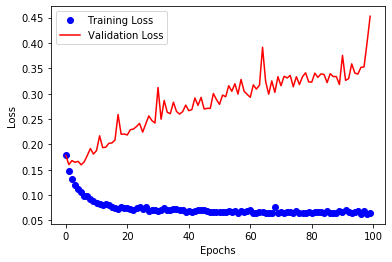

In [119]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Question

Do you think overfitting is happening? If yes, what can you do? Please make necessary changes to the supervised autoencoder network structure.

**Failing to add proper regularization will lose 1~2 scores.**

In [129]:
from keras.layers import Dense, Input
from keras import models, regularizers

input_img = Input(shape=(784,), name='input_img')

# encoder network
encode1 = Dense(128, activation='relu', name='encode1')(input_img)
encode2 = Dense(32, activation='relu', name='encode2')(encode1)
encode3 = Dense(8, activation='relu', name='encode3')(encode2)
# The width of the bottleneck layer must be exactly 2.
bottleneck = Dense(2, activation='relu', name='bottleneck',activity_regularizer=regularizers.l1(10e-5))(encode3)

# decoder network
decode1 = Dense(8, activation='relu', name='decode1')(bottleneck)
decode2 = Dense(32, activation='relu', name='decode2')(decode1)
decode3 = Dense(128, activation='relu', name='decode3')(decode2)
decode4 = Dense(784, activation='relu', name='decode4')(decode3)


# build a classifier upon the bottleneck layer
classifier1 = Dense(128, activation='relu', name='classifier1')(bottleneck)
classifier2 = Dense(128, activation='relu', name='classifier2',activity_regularizer=regularizers.l1(10e-5))(classifier1)
classifier3 = Dense(10, activation='softmax', name='classifier3')(classifier2)

sae = models.Model(input_img, [decode4, classifier3])

sae.compile(loss=['mean_squared_error', 'categorical_crossentropy'],
            loss_weights=[1,0.5], 
            optimizer=optimizers.RMSprop(lr=0.001))

rand_indices = numpy.random.permutation(60000)
train_indices = rand_indices[0:10000]
valid_indices = rand_indices[10000:60000]

x_val = x_train[valid_indices, :]
y_val = y_train_vec[valid_indices, :]

x_tr = x_train[train_indices, :]
y_tr = y_train_vec[train_indices, :]

history = sae.fit(x_tr, [x_tr,y_tr], 
                         batch_size=128, 
                         epochs=100, 
                         validation_data=(x_val, [x_val,y_val]))


Train on 10000 samples, validate on 50000 samples
Epoch 1/100
10000/10000 [==============================] - 5s - loss: 1.1943 - decode4_loss: 0.0861 - classifier3_loss: 2.1867 - val_loss: 1.1493 - val_decode4_loss: 0.0782 - val_classifier3_loss: 2.0920
Epoch 2/100
10000/10000 [==============================] - 2s - loss: 1.1362 - decode4_loss: 0.0773 - classifier3_loss: 2.0731 - val_loss: 1.0969 - val_decode4_loss: 0.0765 - val_classifier3_loss: 1.9237
Epoch 3/100
10000/10000 [==============================] - 2s - loss: 1.0531 - decode4_loss: 0.0746 - classifier3_loss: 1.8797 - val_loss: 1.0399 - val_decode4_loss: 0.0743 - val_classifier3_loss: 1.8622
Epoch 4/100
10000/10000 [==============================] - 2s - loss: 1.0233 - decode4_loss: 0.0740 - classifier3_loss: 1.8296 - val_loss: 1.0614 - val_decode4_loss: 0.0741 - val_classifier3_loss: 1.8687
Epoch 5/100
10000/10000 [==============================] - 2s - loss: 0.9966 - decode4_loss: 0.0737 - classifier3_loss: 1.7673 - val_l

10000/10000 [==============================] - 2s - loss: 0.2189 - decode4_loss: 0.0570 - classifier3_loss: 0.2083 - val_loss: 0.3738 - val_decode4_loss: 0.0577 - val_classifier3_loss: 0.5162
Epoch 41/100
10000/10000 [==============================] - 2s - loss: 0.2170 - decode4_loss: 0.0569 - classifier3_loss: 0.2083 - val_loss: 0.3576 - val_decode4_loss: 0.0574 - val_classifier3_loss: 0.4890
Epoch 42/100
10000/10000 [==============================] - 2s - loss: 0.2111 - decode4_loss: 0.0567 - classifier3_loss: 0.2016 - val_loss: 0.3605 - val_decode4_loss: 0.0572 - val_classifier3_loss: 0.4989
Epoch 43/100
10000/10000 [==============================] - 2s - loss: 0.2088 - decode4_loss: 0.0566 - classifier3_loss: 0.2017 - val_loss: 0.3611 - val_decode4_loss: 0.0573 - val_classifier3_loss: 0.5040
Epoch 44/100
10000/10000 [==============================] - 2s - loss: 0.2050 - decode4_loss: 0.0564 - classifier3_loss: 0.1980 - val_loss: 0.3606 - val_decode4_loss: 0.0571 - val_classifier3_l

10000/10000 [==============================] - 2s - loss: 0.1650 - decode4_loss: 0.0538 - classifier3_loss: 0.1727 - val_loss: 0.3510 - val_decode4_loss: 0.0549 - val_classifier3_loss: 0.5415
Epoch 81/100
10000/10000 [==============================] - 2s - loss: 0.1670 - decode4_loss: 0.0538 - classifier3_loss: 0.1759 - val_loss: 0.3723 - val_decode4_loss: 0.0553 - val_classifier3_loss: 0.5839
Epoch 82/100
10000/10000 [==============================] - 2s - loss: 0.1661 - decode4_loss: 0.0538 - classifier3_loss: 0.1761 - val_loss: 0.3467 - val_decode4_loss: 0.0550 - val_classifier3_loss: 0.5335
Epoch 83/100
10000/10000 [==============================] - 2s - loss: 0.1674 - decode4_loss: 0.0538 - classifier3_loss: 0.1781 - val_loss: 0.3602 - val_decode4_loss: 0.0548 - val_classifier3_loss: 0.5619
Epoch 84/100
10000/10000 [==============================] - 2s - loss: 0.1681 - decode4_loss: 0.0537 - classifier3_loss: 0.1790 - val_loss: 0.3519 - val_decode4_loss: 0.0557 - val_classifier3_l

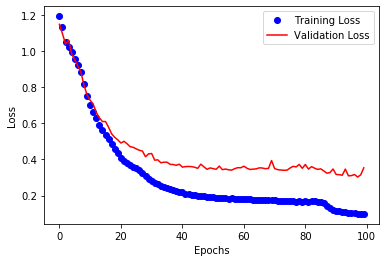

In [130]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 4.3. Visualize the reconstructed test images

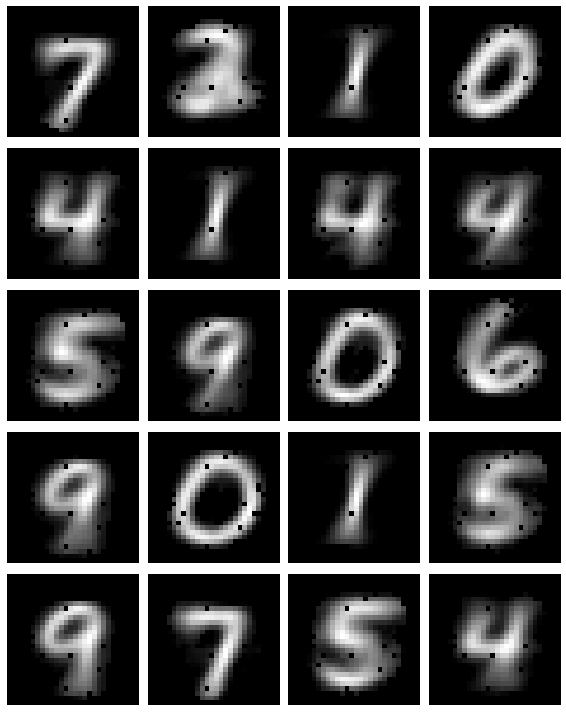

In [131]:
sae_output = sae.predict(x_test)[0].reshape((10000, 28, 28))

ROW = 5
COLUMN = 4

x = sae_output
fname = 'reconstruct_sae.pdf'

fig, axes = plt.subplots(nrows=ROW, ncols=COLUMN, figsize=(8, 10))
for ax, i in zip(axes.flat, numpy.arange(ROW*COLUMN)):
    image = x[i].reshape(28, 28)
    ax.imshow(image, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.savefig(fname)
plt.show()

### 4.4. Visualize the low-dimensional features

In [132]:
# build the encoder model
sae_encoder = models.Model(input_img, bottleneck)
sae_encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 784)               0         
_________________________________________________________________
encode1 (Dense)              (None, 128)               100480    
_________________________________________________________________
encode2 (Dense)              (None, 32)                4128      
_________________________________________________________________
encode3 (Dense)              (None, 8)                 264       
_________________________________________________________________
bottleneck (Dense)           (None, 2)                 18        
Total params: 104,890
Trainable params: 104,890
Non-trainable params: 0
_________________________________________________________________


Shape of encoded_test: (10000, 2)


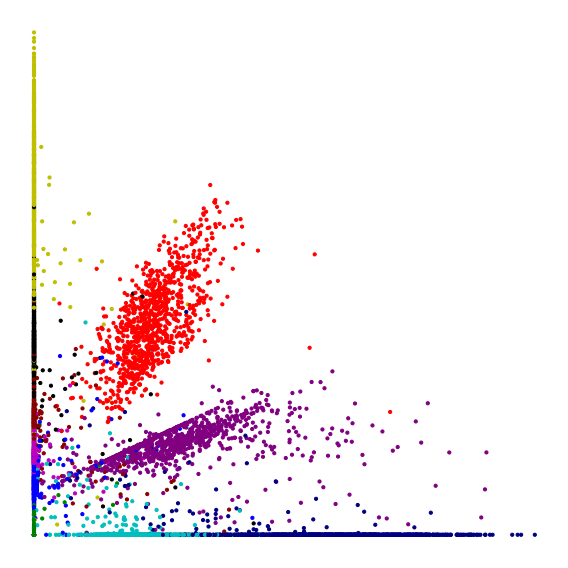

In [133]:
# extract test features
encoded_test = sae_encoder.predict(x_test)
print('Shape of encoded_test: ' + str(encoded_test.shape))

colors = numpy.array(['r', 'g', 'b', 'm', 'c', 'k', 'y', 'purple', 'darkred', 'navy'])
colors_test = colors[y_test]


import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(8, 8))
plt.scatter(encoded_test[:, 0], encoded_test[:, 1], s=10, c=colors_test, edgecolors=colors_test)
plt.axis('off')
plt.tight_layout()
fname = 'sae_code.pdf'
plt.savefig(fname)

### 4.5. Are the learned low-dim features discriminative?

To find the answer, lets train a classifier on the training set (the extracted 2-dim features) and evaluation on the test set.


In [134]:
# extract 2D features from the training, validation, and test samples
f_tr = sae_encoder.predict(x_tr)
f_val = sae_encoder.predict(x_val)
f_te = sae_encoder.predict(x_test)

In [135]:
# build a classifier which takes the 2D features as input
from keras.layers import Dense, Input
from keras import models

input_feat = Input(shape=(2,))

hidden1 = Dense(128, activation='relu')(input_feat)
hidden2 = Dense(128, activation='relu')(hidden1)
output = Dense(10, activation='softmax')(hidden2)

classifier = models.Model(input_feat, output)

classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               384       
_________________________________________________________________
dense_14 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_15 (Dense)             (None, 10)                1290      
Total params: 18,186
Trainable params: 18,186
Non-trainable params: 0
_________________________________________________________________


In [136]:
classifier.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.RMSprop(lr=1E-4),
                  metrics=['acc'])

history = classifier.fit(f_tr, y_tr, 
                        batch_size=32, 
                        epochs=30, 
                        validation_data=(f_val, y_val))

Train on 10000 samples, validate on 50000 samples
Epoch 1/30
10000/10000 [==============================] - 4s - loss: 2.1569 - acc: 0.3400 - val_loss: 2.0131 - val_acc: 0.3642
Epoch 2/30
10000/10000 [==============================] - 3s - loss: 1.8436 - acc: 0.4058 - val_loss: 1.7116 - val_acc: 0.4761
Epoch 3/30
10000/10000 [==============================] - 3s - loss: 1.5265 - acc: 0.6251 - val_loss: 1.4138 - val_acc: 0.6556
Epoch 4/30
10000/10000 [==============================] - 3s - loss: 1.2080 - acc: 0.7584 - val_loss: 1.1295 - val_acc: 0.7829
Epoch 5/30
10000/10000 [==============================] - 3s - loss: 0.9134 - acc: 0.8834 - val_loss: 0.8942 - val_acc: 0.8431
Epoch 6/30
10000/10000 [==============================] - 3s - loss: 0.6776 - acc: 0.9560 - val_loss: 0.7295 - val_acc: 0.8850
Epoch 7/30
10000/10000 [==============================] - 3s - loss: 0.5043 - acc: 0.9853 - val_loss: 0.6232 - val_acc: 0.8948
Epoch 8/30
10000/10000 [==============================] - 3s 

#### Remark:

The validation accuracy must be above 90%. It means the low-dim features learned by the supervised autoencoder are very effective.